In [1]:
%reset -f

import numpy as np
import matplotlib.pyplot as plt
from os import system
from math import floor, log10

## Visualization
from IPython.display import display, clear_output, Pretty

## PFLOTRAN
import jupypft.model as mo
import jupypft.parameter as pm
import jupypft.attachmentRateCFT as arCFT
import jupypft.plotBTC as plotBTC
import jupypft.plotBTC.sci_notation as sci_notation


In [2]:
from sklearn.metrics import mean_squared_log_error as MSLE
from sklearn.metrics import r2_score as r2_score

In [3]:
timePoreVolume = 0.0

def getPV(t):
    return (t * FlowVelocity.value) / (ColumnLenght.value * Porosity.value)  #s

def AssignValues():    
    global timePoreVolume
    timePoreVolume = ColumnLenght.value * Porosity.value / FlowVelocity.value #s
    
    CFL =  1.0
    deltaX = ColumnLenght.value/nZ.value

    #Calculate linked parameters
    ElutionTime.value = InjectTimeInPoreVol * timePoreVolume #s
    EndTime.value     = 3.0 * InjectTimeInPoreVol * timePoreVolume / 3600 #h
    TimeStep.value    = CFL*deltaX*Porosity.value/FlowVelocity.value
    OutTimeStep.value = ElutionTime.value/50.
    
    print("PV -> t = {:.3E} [h]".format(timePoreVolume/3600))
    
def RunAll():
    system("rm -rf pflotran*")
    
    AssignValues()
    
    #Copy the template as a runFile
    ColumnModel.cloneTemplate()
    
    #Replace the tags in the runFile with values
    for parameter in listOfParameters:
        ColumnModel.replaceTagInFile(parameter)
    
    #Run PFLOTRAN
    ColumnModel.runModel()
    
    #Reformat the results file to a CSV
    ColumnModel.fixedToCSV(outputFile="pflotran-obs-0.tec")
    ColumnModel.fixedToCSV(outputFile="pflotran-mas.dat")
    
def ReadResult(file="pflotran-mas.dat",indices = ("Time [h]","Top Vaq [mol/h]")):
    time, conc = plotBTC.get_observationData(file,
                indices = indices,
                normalizeWith = (1.,1.))
    
    return (time,conc)

In [4]:
templateFiles = {"Richards": "../../TEMPLATES/columns_1D/AnalyticalComparisons/tpl_Richards_Bioparticle_Kte.in",
                 "NoFlow"  : "../../TEMPLATES/columns_1D/AnalyticalComparisons/tpl_NoFlow_Bioparticle_Kte.in"}

templateFile = templateFiles["NoFlow"]
#Pretty(templateFiles[0])

ColumnModel = mo.Model(templateFile=templateFile,
                       execPath="$PFLOTRAN_DIR/buildExperimental/pflotran")

In [5]:
Temperature = pm.Real("<referenceTemperature>", value=10.0 , units="C")
ConcentrationAtInlet = pm.Real("<initialConcentration>", value=1.0, units="mol/L")
InjectTimeInPoreVol = 2.0

nX = pm.Integer("<nX>",value=1)
nY = pm.Integer("<nY>",value=1)
nZ = pm.Integer("<nZ>",value=100)

ElutionTime  = pm.Real(tag="<elutionTime>",units="s")
EndTime      = pm.Real(tag="<endTime>", units="d")
TimeStep     = pm.Real(tag="<timeStep>",units="h")
OutTimeStep  = pm.Real(tag="<writeTime>",units="h")

## General
FlowVelocity   = pm.Real(tag="<darcyVel>",units="m/s",mathRep="$$\\vec{q}$$")
ColumnLenght   = pm.Real(tag="<colLenght>",units="m",mathRep="$$L$$")
LongDisp       = pm.Real(tag="<longDisp>",units="m",mathRep="$$\\alpha_L$$")
Porosity       = pm.Real(tag="<porosity>", units="adim",mathRep="$$\\theta$$")
                               
## Reaction rates
RateAttachment = pm.Real(tag="<katt>",units="1/s",mathRep="$$k_{det}$$")
RateDetachment = pm.Real(tag="<kdet>",units="1/s",mathRep="$$k_{det}$$")
decayAqueous   = pm.Real(tag="<decayAq>",units="1/s",mathRep="$$\lambda_{aq}$$")
decayImmobile  = pm.Real(tag="<decayIm>",units="1/s",mathRep="$$\lambda_{im}$$")

In [6]:
## General
Porosity.value     = 0.35
FlowVelocity.value = 0.35E-4
ColumnLenght.value = 1.0
LongDisp.value     = 1.0E-4

## Reaction rates
RateAttachment.value = 0.0
RateDetachment.value = 0.0
decayAqueous.value   = 0.0
decayImmobile.value  = 0.0

listOfParameters = pm.Parameter.list_of_vars()

# Basic Advection-Dispersion 

In [7]:
# Run
RunAll()
# Get results
t, Cpflotran = ReadResult(file="pflotran-mas.dat",indices = ("Time [h]","Top Vaq [mol/h]"))
# Transform
t = t*3600  # Convert to s
Cpflotran = -(Cpflotran/3600.) / (FlowVelocity.value*0.05*0.05*1000) #Convert to concentration

PV -> t = 2.778E+00 [h]


In [8]:
Pe = ColumnLenght.value/LongDisp.value
print(Pe)

10000.0


In [9]:
#Get analytical results
tA,CA = ReadResult(file="STANMOD/AdvDisp.csv",indices = ("Time","Concentration"))

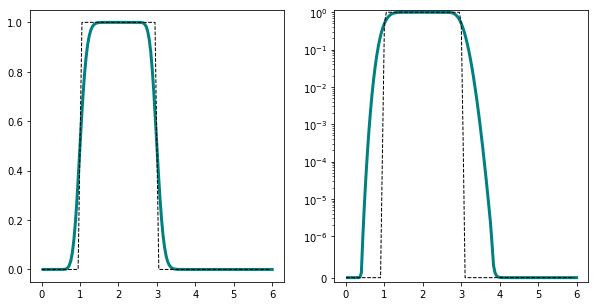

In [10]:
fig,axs = plt.subplots(1,2,figsize=(10,5))
for ax in axs:
    ax.plot(getPV(t),Cpflotran,c='teal',lw=3)
    ax.plot(tA,CA,c='black',lw=1,ls="dashed")

ax.set_yscale("symlog",\
      linthresh=1.0E-6,subs=[1,2,3,4,5,6,7,8,9])
ax.set_ylim([-1.0E-7,1.15])
plt.show()

# One-site kinetic equilibrium

In [22]:
## General
Porosity.value     = 0.35
ColumnLenght.value = 1.0
LongDisp.value     = 1.0E-2
decayAqueous.value   = 0.0
decayImmobile.value  = 0.0
bulkDensity = 1.0

kattArray = [1.0E-4,1.0E-4,1.0E-4]
kdetArray = [1.0E-5,1.0E-6,1.0E-4]
qArray    = [0.35E-4,0.35E-4,0.35E-3]

listFiles = ["R11.csv","R101.csv","R2.csv"]
listColors = ["crimson","indigo","olive"]
listLabels = []

kattArray2  = np.array([1.0E-4, 1.0E-4, 1.0E-4])
kdetArray2  = np.array([1.0E-5, 1.0E-6, 1.0E-4])
qArray2     = np.array([0.35E-4,0.35E-4,0.35E-3])
decAqArray = np.array([2.0E-5, 1.0E-5, 1.0E-5])
decImArray = np.array([1.0E-5, 1.0E-5, 1.0E-3])

listFiles2 = ["CASE1.csv","CASE2.csv","CASE3.csv"]
listColors2 = ["crimson","indigo","olive"]
listLabels2 = []

PV -> t = 2.778E+00 [h]
PV -> t = 2.778E+00 [h]
PV -> t = 2.778E-01 [h]
PV -> t = 2.778E+00 [h]
PV -> t = 2.778E+00 [h]
PV -> t = 2.778E-01 [h]


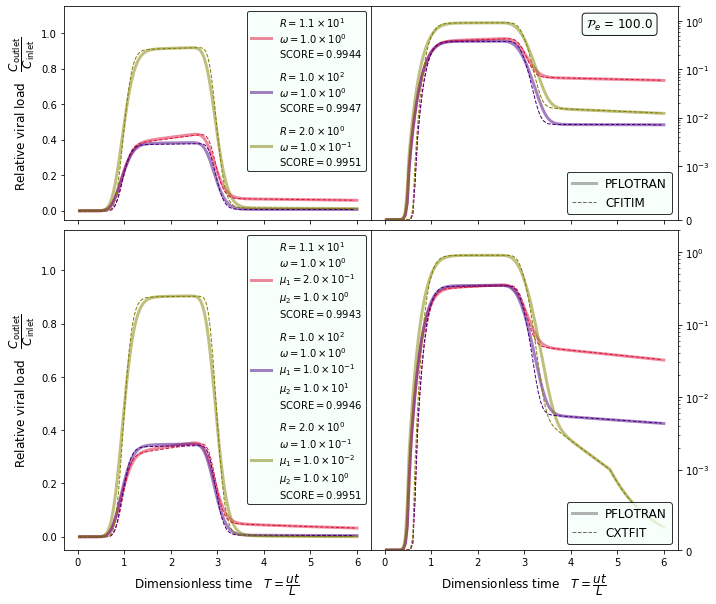

In [23]:
fig,axs = plt.subplots(2,2,sharex=False, sharey=False,\
                  figsize=(11,10),gridspec_kw={"height_ratios":[2,3],"hspace":0.04,"wspace":0}) 

# Legend configuration
import matplotlib.lines as mlines

PFLOTRAN_line = mlines.Line2D([], [], color='dimgray', lw=3, alpha = 0.5,\
                          label='PFLOTRAN')
STANMOD_line = mlines.Line2D([], [], color='dimgray', lw=1, ls="dashed",\
                          label='CFITIM')
STANMO2_line = mlines.Line2D([], [], color='dimgray', lw=1, ls="dashed",\
                          label='CXTFIT')
CASE_line = []
## Reaction rates
for i in range(len(listFiles)):
    RateAttachment.value = kattArray[i]
    RateDetachment.value = kdetArray[i]
    FlowVelocity.value = qArray[i]
    decayAqueous.value   = 0.0
    decayImmobile.value  = 0.0
    
    listOfParameters = pm.Parameter.list_of_vars()

    k     = RateAttachment.value * Porosity.value / (bulkDensity*RateDetachment.value)
    alpha = RateDetachment.value
    R     = 1. + bulkDensity*k/Porosity.value
    Beta  = 1./R
    Omega = alpha * bulkDensity * k * ColumnLenght.value / FlowVelocity.value
    Pe    = ColumnLenght.value/LongDisp.value

    if False:
        print("CASE ",i)
        print("Pe = ", Pe)
        print("R = ",R)
        print("Beta = ",Beta)
        print("Omega = ",Omega)
        print("*****\n")
        
    RunAll()
    
    #Get results PFLOTRAN
    t, Cpflotran = ReadResult(file="pflotran-mas.dat",indices = ("Time [h]","Top Vaq [mol/h]"))
    t = t*3600  # Convert to s
    Cpflotran = -(Cpflotran/3600.) / (FlowVelocity.value*0.05*0.05*1000) #Convert to concentration

    # Get analytical results
    tA,CA = ReadResult(file="STANMOD/CFITIM/"+listFiles[i],\
                       indices = ("Time","Concentration"))
    
    ## Error measurement
    timeModel = getPV(t)
    concModel = Cpflotran
    timeObser = tA
    concObser = CA    
    concModel_r = np.interp(timeObser,timeModel,concModel)
    err = r2_score(y_true=concObser,y_pred=concModel_r)
    
    listLabels.append(r"$R = $" + sci_notation(R) + "\n"\
                      + r"$\omega = $" + sci_notation(Omega) + "\n"\
                      + r"SCORE$ = $" + "{:.4f}".format(err))   
    
    CASE_line.append(mlines.Line2D([], [], color=listColors[i], lw=3, alpha = 0.5,\
                    label=listLabels[i]))
    
    for ax in axs[0]:
        ax.plot(getPV(t),Cpflotran,c=listColors[i],lw=3,alpha=0.5,zorder=1)
        ax.plot(tA,CA,c=listColors[i],lw=1,ls="dashed",zorder=2)
        
font = {'size': 12}  
ax = axs[0,0]
ax.set(ylim=[-0.05,1.15])
ax.set_ylabel("Relative viral load   " + r"$\dfrac{C_{\rm outlet}}{C_{\rm inlet}}}$",fontdict=font)
#ax.set_xlabel("Dimensionless time   " + r"$T = \dfrac{ut}{L}$",fontdict=font)
ax.legend(handles=CASE_line,
          loc='upper right',ncol=1,
          edgecolor='k',facecolor='mintcream',labelspacing=1)
ax.axes.xaxis.set_ticklabels([])

#ax.legend(handles=CASE_line,bbox_to_anchor=(1.5,0.5),
#          loc='upper right',ncol=1,
#          edgecolor='k',facecolor='mintcream',labelspacing=1)

ax = axs[0,1]
ax.set_yscale("symlog",\
      linthresh=1.0E-3,subs=[1,2,3,4,5,6,7,8,9])
ax.set_ylim([-1.0E-7,2.0])
#ax.set_xlabel("Dimensionless time   " + r"$T = \dfrac{ut}{L}$",fontdict=font)
ax.legend(handles=[PFLOTRAN_line,STANMOD_line],loc='lower right',
          edgecolor='k',facecolor='mintcream',labelspacing=0.5,
          fontsize=12)
ax.yaxis.tick_right()
ax.axes.xaxis.set_ticklabels([])

## Parameter info:
information = \
    r"$\mathcal{P}_e$" + " = {:.1f} ".format(Pe)
bbox = dict(boxstyle='round', facecolor='mintcream', alpha=0.90)
ax.text(0.7,0.9,information,bbox=bbox,transform=ax.transAxes,\
        fontsize=12)
CASE_line = []

#################################################
## Reaction rates
for i in range(len(listFiles2)):

    RateAttachment.value = kattArray2[i]
    RateDetachment.value = kdetArray2[i]
    decayAqueous.value   = decAqArray[i]
    decayImmobile.value  = decImArray[i]
    FlowVelocity.value = qArray2[i]

    listOfParameters = pm.Parameter.list_of_vars()
    
    u     = FlowVelocity.value/Porosity.value
    k     = RateAttachment.value * Porosity.value / (bulkDensity*RateDetachment.value)
    alpha = RateDetachment.value
    R     = 1. + bulkDensity*k/Porosity.value
    Beta  = 1./R
    Omega = alpha * bulkDensity * k * ColumnLenght.value / FlowVelocity.value
    Pe    = ColumnLenght.value/LongDisp.value
    mu1   = ColumnLenght.value*decayAqueous.value/u
    mu2   = ColumnLenght.value*(R-1.)*decayImmobile.value/u
      
    if False:
        print("CASE ",i)
        print("u = ", u)
        print("D = ", u*LongDisp.value)

        print("Pe = ", Pe)
        print("R = ",R)
        print("Beta = ",Beta)
        print("Omega = ",Omega)
        print("Mu1 = ",mu1)
        print("Mu2 = ",mu2)
        print("*****\n")
        
    RunAll()
    
    #Get results PFLOTRAN
    t, Cpflotran = ReadResult(file="pflotran-mas.dat",indices = ("Time [h]","Top Vaq [mol/h]"))
    t = t*3600  # Convert to s
    Cpflotran = -(Cpflotran/3600.) / (FlowVelocity.value*0.05*0.05*1000) #Convert to concentration

    # Get analytical results
    tA,CA = ReadResult(file="STANMOD/CXTFIT/"+listFiles2[i],\
                       indices = ("Time","C1"))
    
    ## Error measurement
    timeModel = getPV(t)
    concModel = Cpflotran
    timeObser = tA
    concObser = CA    
    concModel_r = np.interp(timeObser,timeModel,concModel)
    err = r2_score(y_true=concObser,y_pred=concModel_r)
 
    listLabels2.append(r"$R =$" + sci_notation(R) + "\n" \
          + r"$\omega =$" + sci_notation(Omega) + "\n" \
          + r"$\mu_1 =$"  + sci_notation(mu1) + "\n" \
          + r"$\mu_2 =$"  + sci_notation(mu2)+ "\n" \
          + r"SCORE$ = $" + "{:.4f}".format(err))
    
    CASE_line.append(mlines.Line2D([], [], color=listColors2[i], lw=3, alpha = 0.5,\
                    label=listLabels2[-1]))
    
    for ax in axs[1]:
        ax.plot(getPV(t),Cpflotran,c=listColors2[i],lw=3,alpha=0.5,zorder=1)
        ax.plot(tA,CA,c=listColors2[i],lw=1,ls="dashed",zorder=2)
       
#*****************
font = {'size': 12}  
ax = axs[1,0]
ax.set(ylim=[-0.05,1.15])
ax.set_ylabel("Relative viral load   " + r"$\dfrac{C_{\rm outlet}}{C_{\rm inlet}}}$",fontdict=font)
ax.set_xlabel("Dimensionless time   " + r"$T = \dfrac{ut}{L}$",fontdict=font)
ax.legend(handles=CASE_line,
          loc='upper right',ncol=1,
          edgecolor='k',facecolor='mintcream',labelspacing=1)

ax = axs[1,1]
ax.set_yscale("symlog",\
      linthresh=1.0E-3,subs=[1,2,3,4,5,6,7,8,9])
ax.set_ylim([-1.0E-7,2.0])
ax.set_xlabel("Dimensionless time   " + r"$T = \dfrac{ut}{L}$",fontdict=font)
ax.legend(handles=[PFLOTRAN_line,STANMO2_line],loc='lower right',
          edgecolor='k',facecolor='mintcream',labelspacing=0.5,
          fontsize=12)
ax.yaxis.tick_right()

#plt.tight_layout()
plt.show()

# One-site kinetic equilibrium with decay

In [63]:
## General
Porosity.value     = 0.35
ColumnLenght.value = 1.0
LongDisp.value     = 1.0E-2
decayAqueous.value   = 0.0
decayImmobile.value  = 0.0
bulkDensity = 1.0

kattArray2  = np.array([1.0E-4, 1.0E-4, 1.0E-4])
kdetArray2  = np.array([1.0E-5, 1.0E-6, 1.0E-4])
qArray2     = np.array([0.35E-4,0.35E-4,0.35E-3])
decAqArray = np.array([2.0E-5, 1.0E-5, 1.0E-5])
decImArray = np.array([1.0E-5, 1.0E-5, 1.0E-3])

listFiles2 = ["CASE1.csv","CASE2.csv","CASE3.csv"]
listColors2 = ["crimson","indigo","olive"]
listLabels2 = []

CASE  0
u =  9.999999999999999e-05
D =  1e-06
Pe =  100.0
R =  11.0
Beta =  0.09090909090909091
Omega =  1.0
Mu1 =  0.20000000000000004
Mu2 =  1.0000000000000002
*****

PV -> t = 2.778E+00 [h]
CASE  1
u =  9.999999999999999e-05
D =  1e-06
Pe =  100.0
R =  101.0
Beta =  0.009900990099009901
Omega =  1.0
Mu1 =  0.10000000000000002
Mu2 =  10.000000000000002
*****

PV -> t = 2.778E+00 [h]
CASE  2
u =  0.001
D =  1e-05
Pe =  100.0
R =  2.0
Beta =  0.5
Omega =  0.09999999999999999
Mu1 =  0.01
Mu2 =  1.0
*****

PV -> t = 2.778E-01 [h]


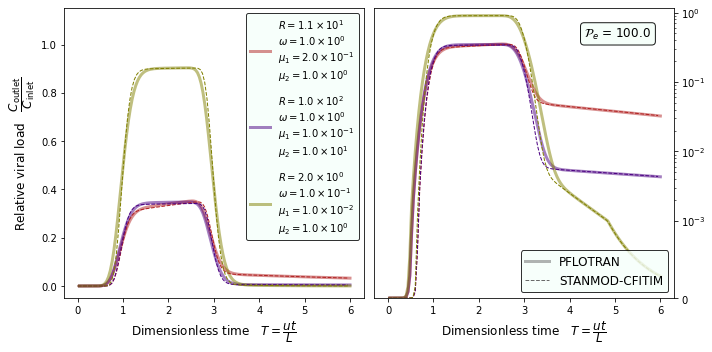

In [52]:
fig,axs = plt.subplots(1,2,figsize=(10,5))

plt.subplots_adjust(wspace=0.1,hspace=0.4)

# Legend configuration
import matplotlib.lines as mlines

PFLOTRAN_line = mlines.Line2D([], [], color='dimgray', lw=3, alpha = 0.5,\
                          label='PFLOTRAN')
STANMOD_line = mlines.Line2D([], [], color='dimgray', lw=1, ls="dashed",\
                          label='STANMOD-CFITIM')
CASE_line = []

## Reaction rates
for i in range(len(listFiles2)):
#for i in [2]:
    RateAttachment.value = kattArray2[i]
    RateDetachment.value = kdetArray2[i]
    decayAqueous.value   = decAqArray[i]
    decayImmobile.value  = decImArray[i]
    FlowVelocity.value = qArray2[i]

    listOfParameters = pm.Parameter.list_of_vars()
    
    u     = FlowVelocity.value/Porosity.value
    k     = RateAttachment.value * Porosity.value / (bulkDensity*RateDetachment.value)
    alpha = RateDetachment.value
    R     = 1. + bulkDensity*k/Porosity.value
    Beta  = 1./R
    Omega = alpha * bulkDensity * k * ColumnLenght.value / FlowVelocity.value
    Pe    = ColumnLenght.value/LongDisp.value
    mu1   = ColumnLenght.value*decayAqueous.value/u
    mu2   = ColumnLenght.value*(R-1.)*decayImmobile.value/u
    
    listLabels2.append(r"$R =$" + sci_notation(R) + "\n" \
          + r"$\omega =$" + sci_notation(Omega) + "\n" \
          + r"$\mu_1 =$"  + sci_notation(mu1) + "\n" \
          + r"$\mu_2 =$"  + sci_notation(mu2))
    
    if True:
        print("CASE ",i)
        print("u = ", u)
        print("D = ", u*LongDisp.value)

        print("Pe = ", Pe)
        print("R = ",R)
        print("Beta = ",Beta)
        print("Omega = ",Omega)
        print("Mu1 = ",mu1)
        print("Mu2 = ",mu2)
        print("*****\n")
        
    RunAll()
    
    #Get results PFLOTRAN
    t, Cpflotran = ReadResult(file="pflotran-mas.dat",indices = ("Time [h]","Top Vaq [mol/h]"))
    t = t*3600  # Convert to s
    Cpflotran = -(Cpflotran/3600.) / (FlowVelocity.value*0.05*0.05*1000) #Convert to concentration

    # Get analytical results
    tA,CA = ReadResult(file="STANMOD/CXTFIT/"+listFiles2[i],\
                       indices = ("Time","C1"))
    
    CASE_line.append(mlines.Line2D([], [], color=listColors2[i], lw=3, alpha = 0.5,\
                    label=listLabels2[-1]))
    
    for ax in axs:
        ax.plot(getPV(t),Cpflotran,c=listColors[i],lw=3,alpha=0.5,zorder=1)
        ax.plot(tA,CA,c=listColors[i],lw=1,ls="dashed",zorder=2)
        
font = {'size': 12}  
ax = axs[0]
ax.set(ylim=[-0.05,1.15])
ax.set_ylabel("Relative viral load   " + r"$\dfrac{C_{\rm outlet}}{C_{\rm inlet}}}$",fontdict=font)
ax.set_xlabel("Dimensionless time   " + r"$T = \dfrac{ut}{L}$",fontdict=font)
ax.legend(handles=CASE_line,
          loc='upper right',ncol=1,
          edgecolor='k',facecolor='mintcream',labelspacing=1)

ax = axs[1]
ax.set_yscale("symlog",\
      linthresh=1.0E-3,subs=[1,2,3,4,5,6,7,8,9])
ax.set_ylim([-1.0E-7,1.15])
ax.set_xlabel("Dimensionless time   " + r"$T = \dfrac{ut}{L}$",fontdict=font)
ax.legend(handles=[PFLOTRAN_line,STANMOD_line],loc='lower right',
          edgecolor='k',facecolor='mintcream',labelspacing=0.5,
          fontsize=12)
ax.yaxis.tick_right()

## Parameter info:
information = \
    r"$\mathcal{P}_e$" + " = {:.1f} ".format(Pe)
bbox = dict(boxstyle='round', facecolor='mintcream', alpha=0.90)
ax.text(0.7,0.9,information,bbox=bbox,transform=ax.transAxes,\
        fontsize=12)

plt.tight_layout()
plt.show()

In [14]:
## General
Porosity.value     = 0.35
FlowVelocity.value = 0.35E-4
ColumnLenght.value = 1.0
LongDisp.value     = 1.0E-2

## Reaction rates
RateAttachment.value = 1.0E-4
RateDetachment.value = 1.0E-5
decayAqueous.value   = 2.0E-5
decayImmobile.value  = 1.0E-5

listOfParameters = pm.Parameter.list_of_vars()

In [15]:
bulkDensity = 1.0

u = FlowVelocity.value/Porosity.value
k = RateAttachment.value * Porosity.value / (bulkDensity*RateDetachment.value)
alpha = RateDetachment.value

R = 1. + bulkDensity*k/Porosity.value
Beta = 1./R
Omega = alpha * bulkDensity * k * ColumnLenght.value / FlowVelocity.value
Pe = ColumnLenght.value/LongDisp.value
mu1 = ColumnLenght.value*decayAqueous.value/u
mu2 = ColumnLenght.value*(R-1.)*decayImmobile.value/u

print("u = ", u)
print("D = ", u*LongDisp.value)

print("Pe = ", Pe)
print("R = ",R)
print("Beta = ",Beta)
print("Omega = ",Omega)
print("Mu1 = ",mu1)
print("Mu2 = ",mu2)


u =  9.999999999999999e-05
D =  1e-06
Pe =  100.0
R =  11.0
Beta =  0.09090909090909091
Omega =  1.0
Mu1 =  0.20000000000000004
Mu2 =  1.0000000000000002


In [16]:
RunAll()

PV -> t = 2.778E+00 [h]


In [17]:
#Get results
t, Cpflotran = ReadResult(file="pflotran-mas.dat",indices = ("Time [h]","Top Vaq [mol/h]"))
t = t*3600  # Convert to s
Cpflotran = -(Cpflotran/3600.) / (FlowVelocity.value*0.05*0.05*1000) #Convert to concentration

In [18]:
# Get analytical results
tA,CA = ReadResult(file="STANMOD/CXTFIT/CASE1.csv",indices = ("Time","C1"))

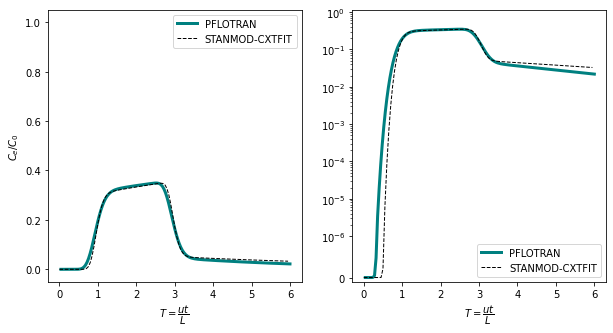

In [19]:
fig,axs = plt.subplots(1,2,figsize=(10,5))
for ax in axs:
    ax.plot(getPV(t),Cpflotran,c='teal',lw=3,label="PFLOTRAN")
    ax.plot(tA,CA,c='black',lw=1,ls="dashed",label="STANMOD-CXTFIT")
    ax.set(xlabel="$T = \dfrac{ut}{L}$")
    ax.legend()
    ax = axs[0]


ax = axs[0]
ax.set(ylim=[-0.05,1.05],ylabel="$C_e/C_0$")

ax = axs[1]
ax.set_yscale("symlog",\
      linthresh=1.0E-6,subs=[1,2,3,4,5,6,7,8,9])
ax.set_ylim([-1.0E-7,1.15])

plt.show()